## Notebook to obtain Spectra and SEDs corresponding to custom input Star Formation and Metallicity Histories using the FSPS package. 

### v 0.1: Basic functionality, creates a spectrum and GOODS-S SED in $F_\nu$ with an input grid of SFR at each time and metallicity, contains dust, a Cloudy pre-grid for nebular emission, and Madau IGM absorption.

Once finalized, this can be rewritten as a script to process batch files and optimized to requisite input data structures, filter curves and other specifications.

generated initial stellar population


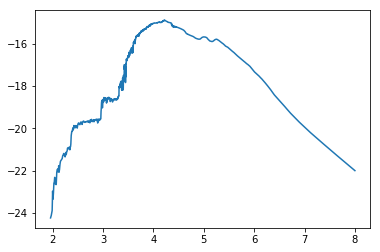

<Quantity 5.74698053003206 Gyr>

In [1]:
from numpy import linalg as LA
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import random as rn
import os
import warnings
import random
from tqdm import tqdm
import time

import matplotlib
cmap = matplotlib.cm.get_cmap('magma')

# not all of these dependencies are necessary, will prune once code is finalised.

# Import the FSPS package, and initialise a stellar population. 
# This takes time and memory, so best to do it just once and pass it as an argument to later functions

import fsps
mocksp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1,sfh=0, imf_type=1, logzsol=0.0, dust_type=2, dust2=0.0, add_neb_emission=True)
print('generated initial stellar population')
[lam,temp] = mocksp.get_spectrum(tage = 5.9)
plt.plot(np.log10(lam),np.log10(temp))
plt.show()

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cosmo.age(1)




# Inputs - 

- time array
- metallicity array [unless it is hardcoded]
- SFH data - in bins of time and metallicity 
- [check for format, bin edges, whether the quantity being supplied is SFR in each bin, at each time point, or stellar mass in each bin, convert all to a common format of SFR/time]

- tailor code to input data in HDF5.

In [217]:
# Function to create spectra for an input SFH, at a single value of metallicity and dust. 

def generate_spectra(sfh ,sp, timeax, cosmo,redshift, dustval = 0.0, metallicity = 0.0, vb = False):

    # function to generate spectra using FSPS corresponding to a given SFH (single or set of SFHs)
    
    # edge cases to test where FSPS doesn't produce output (but doesn't create errors either):
    # time axis is monotonically increasing
    # time axis is in Gyr
    # SFH is positive definite
    
    lam_z, lam_z_lores, filcurves, centers = load_filcurves(redshift)

    ageuniv = cosmo.age(redshift).value
    ags = timeax
    #ags = ags*ageuniv/np.amax(ags)

    if vb == True:
        print(str(ageuniv)+' Gyr at redshift '+str(redshift))
        print('have dust, metval, and inputs')
        print(sfh.shape)
        print('imported stellarpopulation')
        [lam,temp] = sp.get_spectrum(tage = ageuniv)

    sp.params["dust2"] = dustval
    sp.params["logzsol"] = metallicity
    sp.params["sfh"] = 3
    sp.params["add_igm_absorption"] = True
    sp.params["zred"] = redshift

    #spectrum = np.zeros((len(lam),))
    #seds = np.zeros((len(centers),))

    sp.set_tabular_sfh(ags, sfh)
    [lam,spectrum] = sp.get_spectrum(tage = ageuniv)
    fmass = sp.stellar_mass
    #print(str(np.log10(fmass))+' and SFR: '+str(mocksp.sfr))
    #seds[0:,i] = filvals_fsps_fnu(spectra[0:,i],1,lam)
    temp2 = convert_to_microjansky(spectrum,redshift,cosmo)
    sed = generate_SEDs(temp2,redshift,lam,lam_z,lam_z_lores,filcurves)

    #return spectrum, sed, lam
    return temp2, sed, lam

# Function to convert a spectrum from F_\lambda to F_\nu units 

def convert_to_microjansky(spec, z ,cosmo):
    # 1e6 for Jansky to microJansky
    # 3.48e33 for solar luminosity in ergs/s
    # 3.086e+24 for Mpc to cm in dL
    temp = spec *1e6 * 1e23*3.48e33*(1+z)/(4*np.pi*3.086e+24*3.086e+24*cosmo.luminosity_distance(z).value*cosmo.luminosity_distance(z).value)
    return temp

# loading filter curves. generalize this to any filter set
# instead of loading filcurves, rewrite so that there's a function to read input filter curves from a folder and do this
# perhaps have a text file so that 

def load_filcurves(redshift):
    kitname = '/home/kiyer/Documents/dense_basis_mpi_reload/vac/fkilt/codex_filter_val_kit_fsps_'+str(redshift)+'.mat'
    filt_data = sio.loadmat(kitname)
    lam_z = np.array(filt_data['lambda_z'])
    lam_z_lores = np.array(filt_data['lambda_z_lores'])
    filcurves = np.array(filt_data['filtercurve'])
    centers = np.array([3734,3722,4317,5918,7693,8047,9055,9851,10550,12486,15370,21605,21463,35508,44960,57245,78840])
    return lam_z, lam_z_lores, filcurves, centers

# Function to multiply an input spectrum by filter curves to obtain an SED.

def generate_SEDs(spec ,z ,lam ,lam_z ,lam_z_lores, filcurves):

    # function to multiply a spectrum (or set of spectra) with the CANDELS filter curves
    # in appropriate units to generate an SED in microJansky

    lam_z_input = lam*(1+z)
    nu = 3e18/lam_z
    # change this to appropriate normalisation. see documentation.
    fnuspec = spec

    filvals = np.zeros((filcurves.shape[1],))
    for tindex in range(filcurves.shape[1]):
        mask = filcurves[0:,tindex]>0
        temp1 = filcurves[mask,tindex]
        temp2 = fnuspec[mask]
        #print(str(temp1.shape)+' and '+str(temp2.shape))
        filvals[tindex] = np.sum(temp1*temp2)/np.sum(filcurves[0:,tindex])

    return filvals

In [37]:
# Load current z~0 catalog - replace with script for getting input files and storing output files.

cat_handle = sio.loadmat('/home/kiyer/Documents/new_SAM_MUFASA_files/sam_z0_sfhs.mat')

galid = cat_handle['galid']
galid_2 = cat_handle['galid_2']
lbt_arr = cat_handle['lbt_arr'].T
met_arr = cat_handle['met_arr'].T
sfh_block = cat_handle['sfh_block']
sfh_sum = cat_handle['sum_sfh']

9.10538374269 9.10528834099


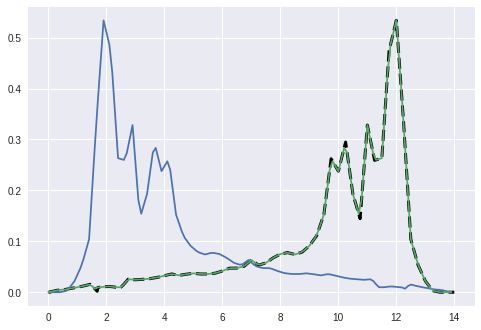

In [242]:
# check if interpolation to a linear time grid works as intended. 
# this is just a placeholder since the actual SAM SFHs will be binned uniformly in time
# and won't need this step

galid = 976
sfh_gal = sfh_block[0:,0:,galid]
sfh_gal.shape
cumulative_sfh = np.sum(sfh_gal,1)
galmass = np.trapz(cumulative_sfh,lbt_arr.ravel()*1e9)
    
timeax = np.arange(np.amin(lbt_arr),np.amax(lbt_arr),0.1)

# the np.flipud is to convert from lookback time to time since big bang, which is what FSPS will use as input
interp_cumulative_sfh = np.flipud(np.interp(timeax,lbt_arr.ravel(),cumulative_sfh))

galmass_interp = np.trapz(interp_cumulative_sfh,timeax.ravel()*1e9)

print(np.log10(galmass),np.log10(galmass_interp))

plt.plot(lbt_arr,cumulative_sfh,'k--',linewidth=3)
plt.plot(timeax,interp_cumulative_sfh)
plt.plot(timeax,np.flipud(interp_cumulative_sfh))
plt.show()


In [248]:
# Obtain a spectrum and SED for a single galaxy at a given epoch of observation.
# - Run the component of the full SFH at each value of metallicity through FSPS and add the results.

def plot_spectrum_cumulative(sfh_block,zobs,galid):


    ageobs = cosmo.age(zobs).value
    sfh_gal = sfh_block[0:,0:,galid]
    cumulative_sfh = np.sum(sfh_gal,1)


    timeax = np.arange(np.amin(lbt_arr),np.amax(lbt_arr),0.1)
    centers = np.array([3734,3722,4317,5918,7693,8047,9055,9851,10550,12486,15370,21605,21463,35508,44960,57245,78840])

    fig = plt.figure(figsize=(15,4))

    spec_cumulative = np.zeros((temp.shape))
    sed_cumulative = np.zeros((len(centers),))
    for i in (range(len(met_arr))):
        sfhin = sfh_gal[0:,i]
        interp_sfhin = np.flipud(np.interp(timeax,lbt_arr.ravel(),sfhin))


        plt.subplot(1,2,1)
        plt.plot(timeax,interp_sfhin,color = cmap(1-i/12))

        spec,sed,lam = generate_spectra((interp_sfhin) ,mocksp, timeax, cosmo,redshift=zobs, dustval = 0.0, metallicity = met_arr[i], vb = False)
        # check direction of time axis and decide whether to flip time axis
        #spec,sed,lam = generate_spectra(np.flipud(interp_sfhin) ,mocksp, timeax, cosmo,redshift=zobs, dustval = 0.0, metallicity = met_arr[i], vb = False)


        spec_cumulative = spec_cumulative + spec
        sed_cumulative = sed_cumulative + sed


        plt.subplot(1,2,2)
        plt.plot(np.log10(lam*(1+zobs)),spec,color = cmap(1-i/12))
        #plt.plot(np.log10(centers),sed,'ko',markersize=9)


    plt.subplot(1,2,1)
    plt.plot(14.0-lbt_arr,cumulative_sfh,'k--',linewidth=3,label='cumulative SFH')
    plt.plot([ageobs,ageobs],[0,np.amax(cumulative_sfh)],'k--',label='obs at z='+str(zobs))
    plt.xlabel('time from big bang [Gyr]',fontsize=18)
    plt.ylabel(r'SFR(t) [$M_\circ.yr^{-1}$]',fontsize=18)
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(np.log10(lam*(1+zobs)),spec_cumulative,'k--',linewidth=2,label='cumulative Spectrum')
    plt.plot(np.log10(centers),sed_cumulative,'o',markersize=9,markeredgecolor='w',label='cumulative SED [GOODS-S]')
    plt.axis([3.5,5,1e-3,np.amax(sed_cumulative)*1.5])
    plt.xlabel(r'log  $\lambda [\AA]$',fontsize=18)
    plt.ylabel(r'$F_\nu [\mu Jy]$',fontsize=18)
    plt.legend()
    #plt.yscale('log')
    plt.show()

## Examples of the run for a single galaxy at $z_{obs}$ = 1,2,3. The thin solid lines show individual components at different values of metallicity, while the black dashed line shows the cumulative SFH. A similar plot is shown on the right in SED space, with individual contributions generated at different metallicities being summed up to obtain the full SED.

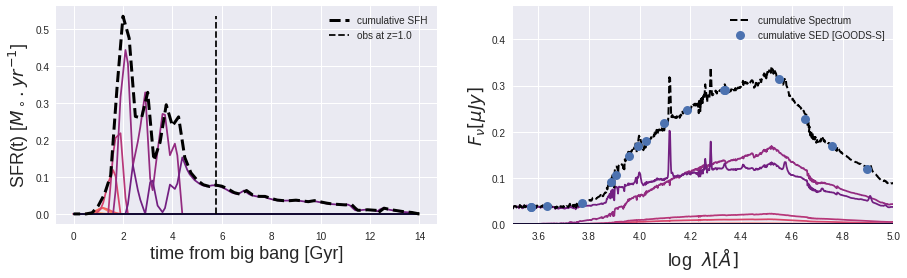

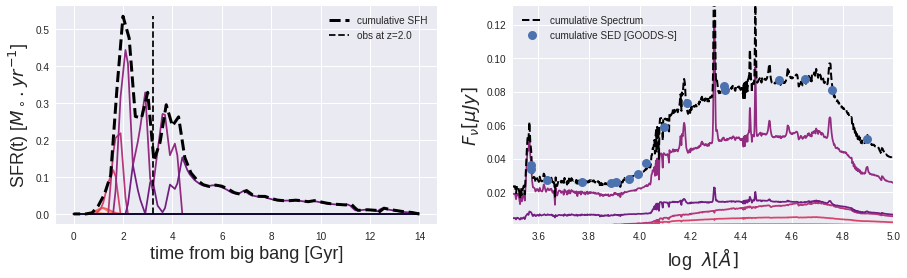

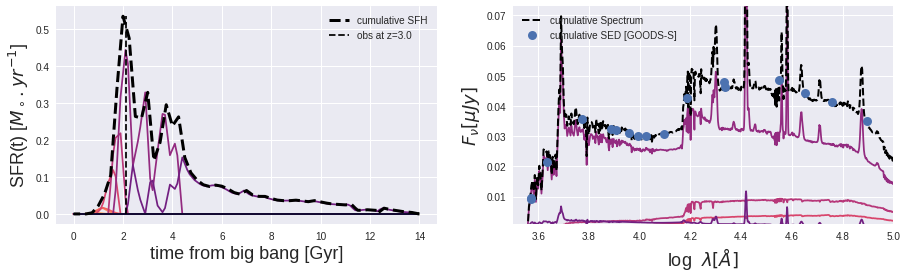

In [249]:
plot_spectrum_cumulative(sfh_block,zobs = 1.0,galid = 976)
plot_spectrum_cumulative(sfh_block,zobs = 2.0,galid = 976)
plot_spectrum_cumulative(sfh_block,zobs = 3.0,galid = 976)

### Another example for a different galaxy, showing how the contributions to the SED at high redshift come from the low metallicity portions (lighter colors) and the low-redshift contributions come from the high-metallicity components (darker colors) of the SFH. 

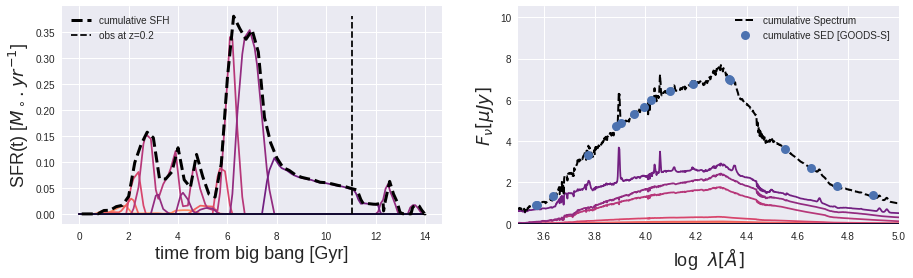

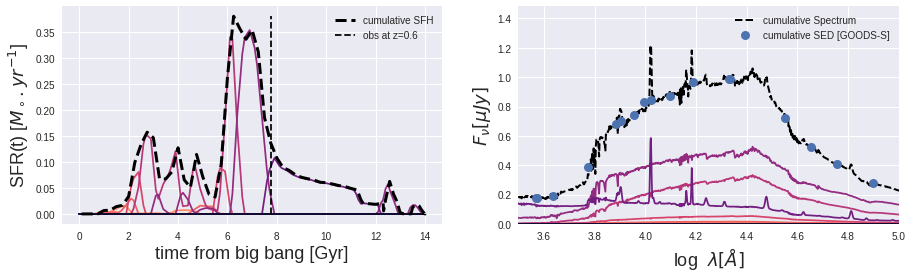

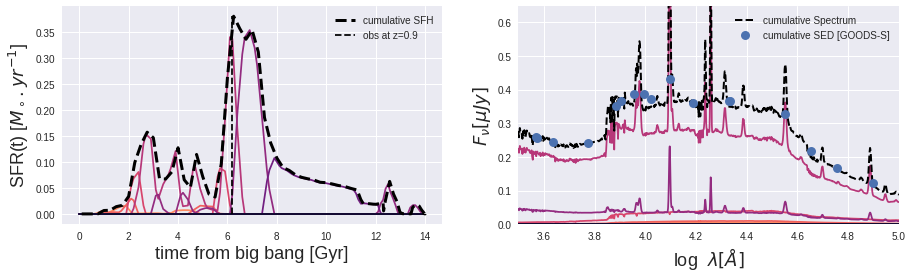

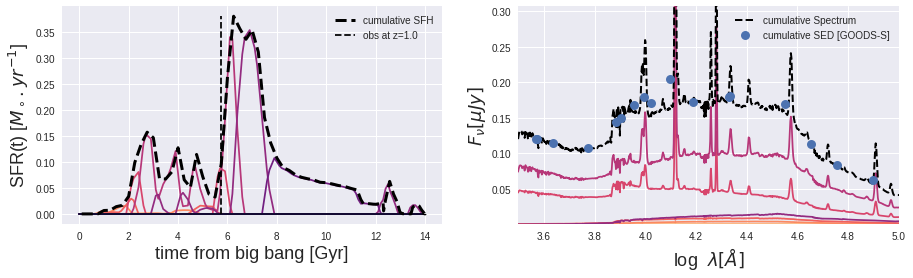

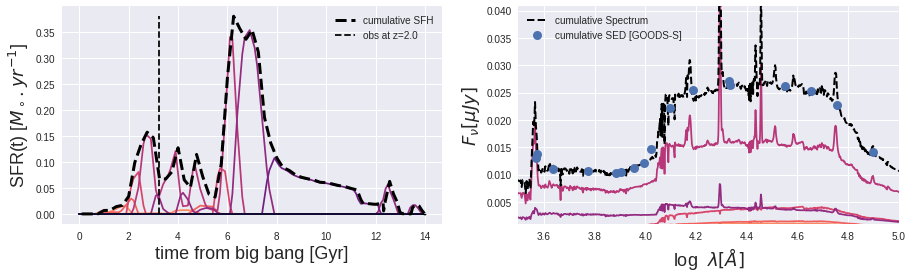

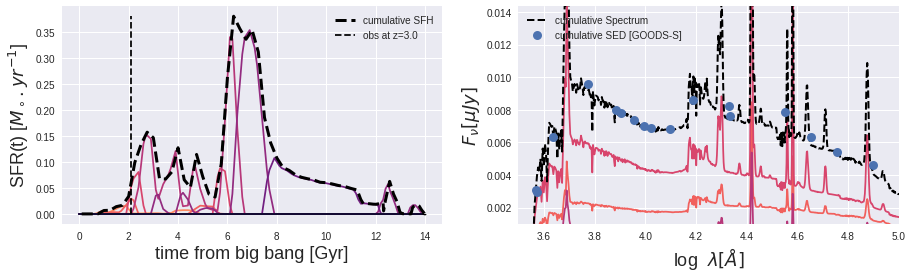

In [250]:
plot_spectrum_cumulative(sfh_block,zobs = 0.2,galid = 1501)
plot_spectrum_cumulative(sfh_block,zobs = 0.6,galid = 1501)
plot_spectrum_cumulative(sfh_block,zobs = 0.9,galid = 1501)
plot_spectrum_cumulative(sfh_block,zobs = 1.0,galid = 1501)
plot_spectrum_cumulative(sfh_block,zobs = 2.0,galid = 1501)
plot_spectrum_cumulative(sfh_block,zobs = 3.0,galid = 1501)

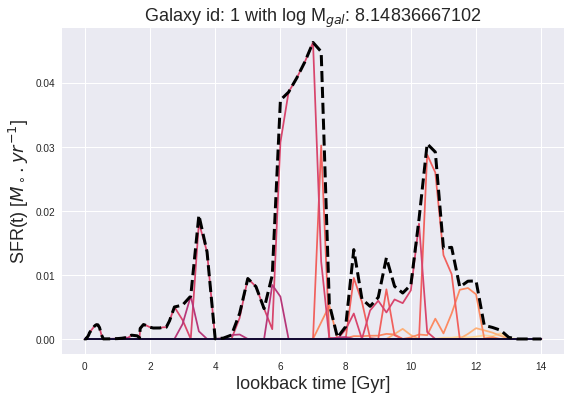

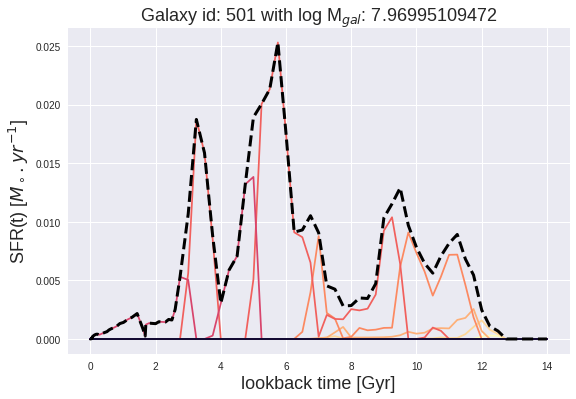

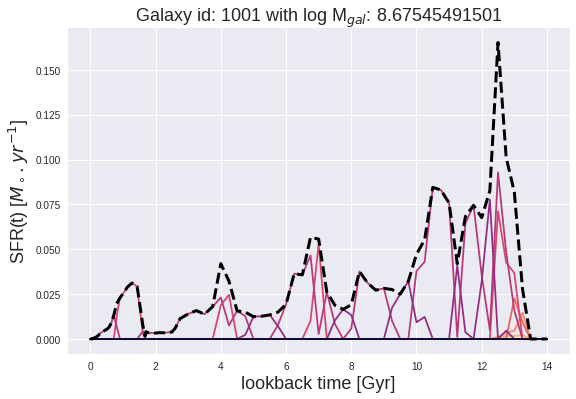

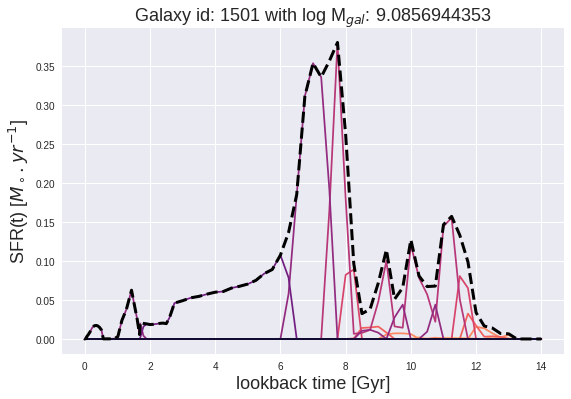

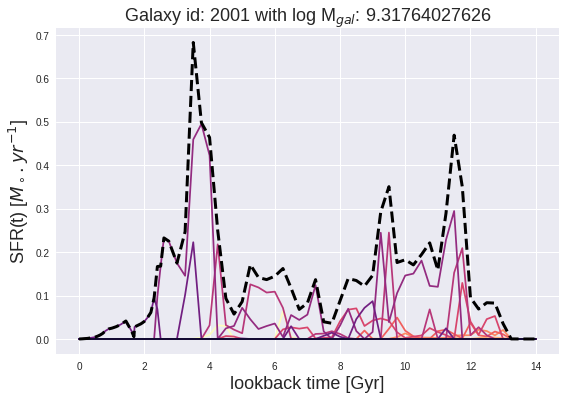

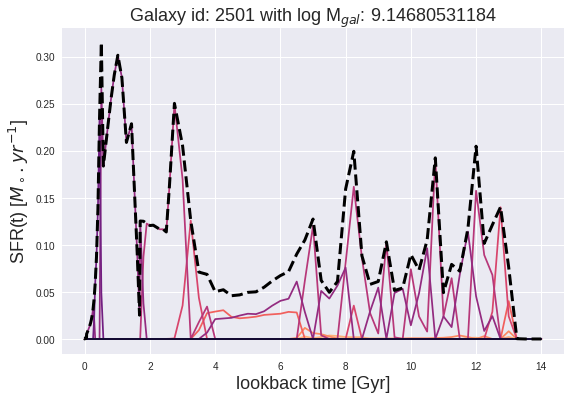

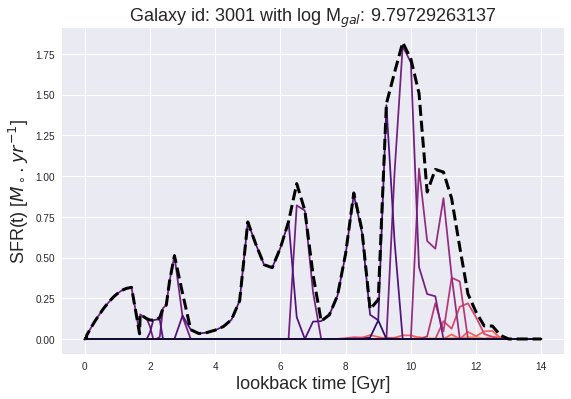

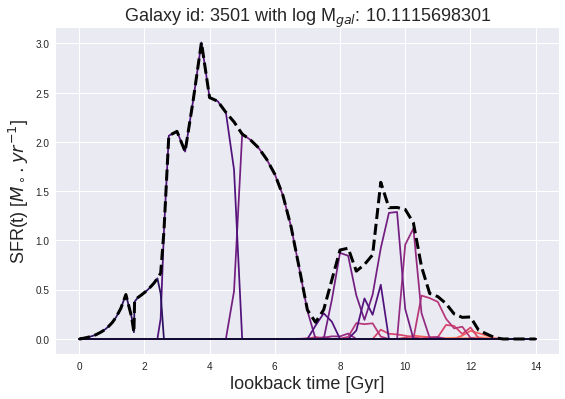

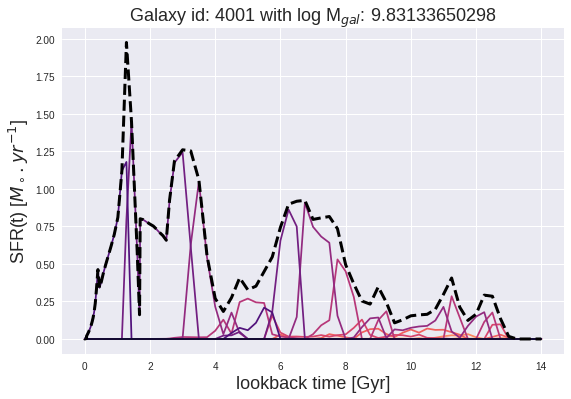

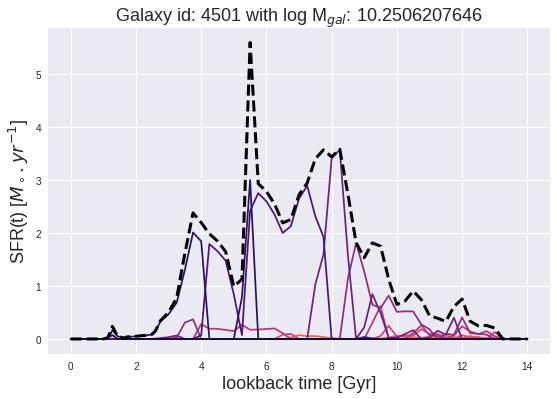

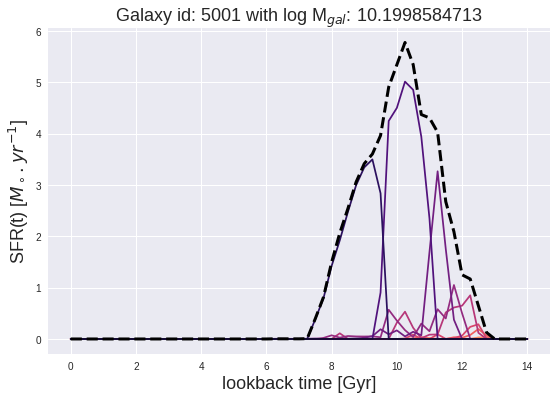

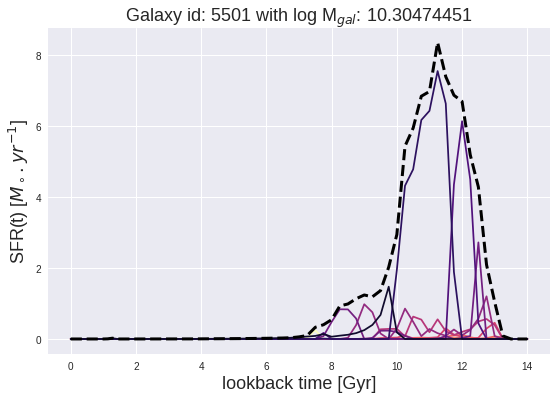

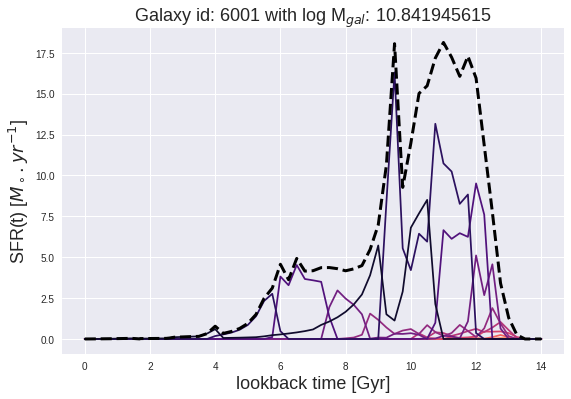

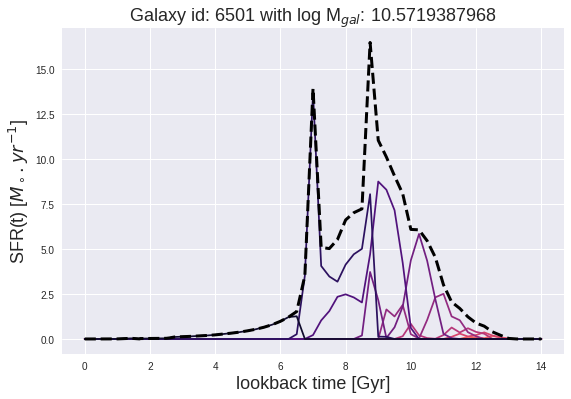

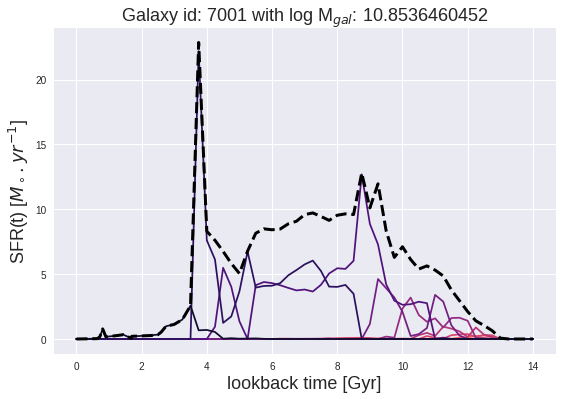

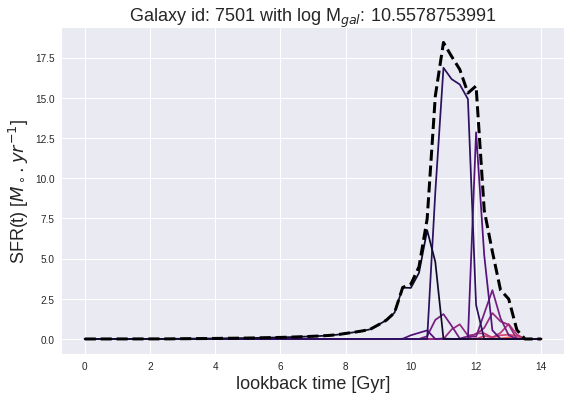

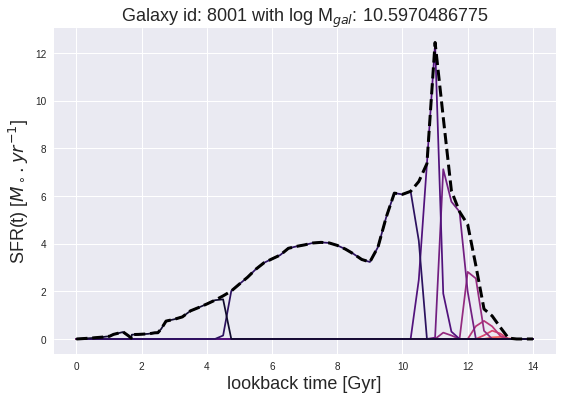

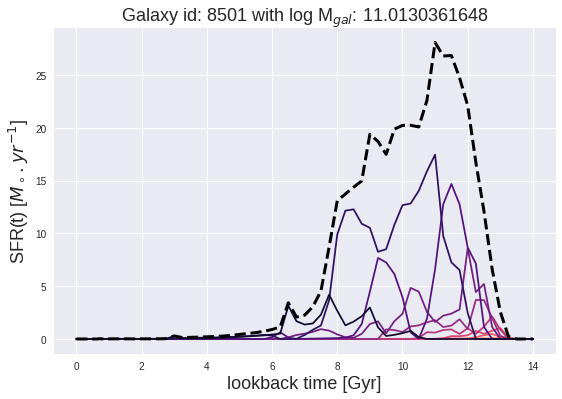

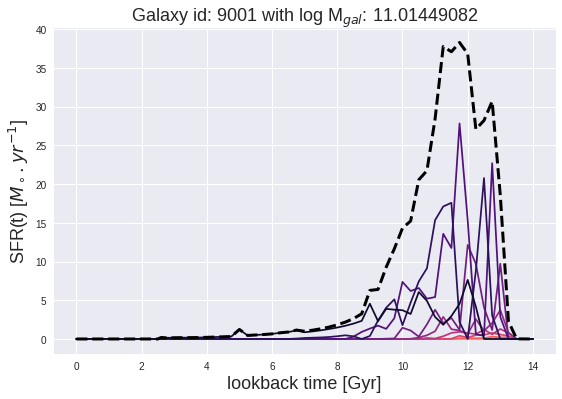

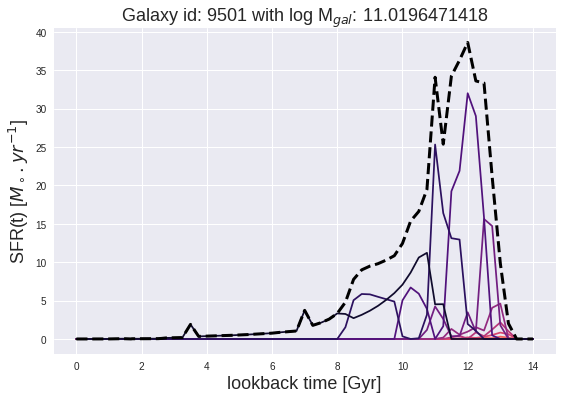

In [81]:
for galid in np.arange(1,10000,500):
    sfh_gal = sfh_block[0:,0:,galid]
    sfh_gal.shape
    cumulative_sfh = np.sum(sfh_gal,1)
    galmass = np.trapz(cumulative_sfh,lbt_arr.ravel()*1e9)
    #if (np.log10(galmass) > 11):
    
    fig = plt.figure(figsize=(9,6))

    for i in range(len(met_arr)):
        plt.plot(lbt_arr,sfh_gal[0:,i],color = cmap(1-i/12))
    plt.plot(lbt_arr,np.sum(sfh_gal,1),'k--',linewidth=3)
    #plt.yscale('log')
    #plt.axis([0,14,1e-3,1e3])
    plt.title(r'Galaxy id: '+str(galid)+' with log M$_{gal}$: '+str(np.log10(galmass)),fontsize=18)
    plt.xlabel('lookback time [Gyr]',fontsize=18)
    plt.ylabel(r'SFR(t) [$M_\circ.yr^{-1}$]',fontsize=18)
    plt.show()
